# Song popularity dataset
Predicting the popularity of a song

### Importing library's

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## EDA

In [116]:
df = pd.read_csv("archive/song_data.csv")
df.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [117]:
df.shape

(18835, 15)

In [118]:
df.drop_duplicates(subset='song_name', keep='first', inplace=True)
df.shape

(13070, 15)

In [119]:
#plt.figure(figsize=(15,15))
#sns.heatmap(df.corr(),annot= True,)
#plt.show()

In [120]:
df = df.drop(['song_name','loudness'], axis=1);
df.shape

(13070, 13)

(array([11054.,   297.,   196.,   138.,   115.,   128.,   124.,   216.,
          380.,   422.]),
 array([0.    , 0.0997, 0.1994, 0.2991, 0.3988, 0.4985, 0.5982, 0.6979,
        0.7976, 0.8973, 0.997 ]),
 <BarContainer object of 10 artists>)

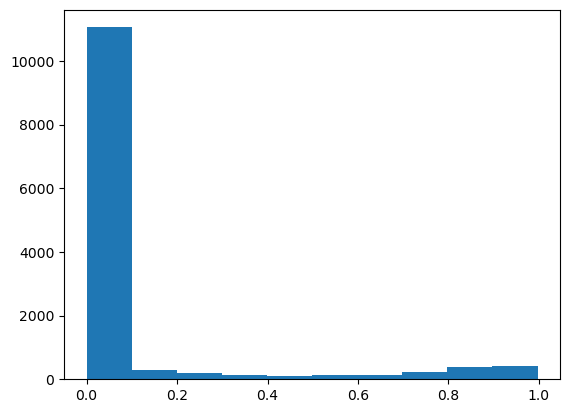

In [121]:
plt.hist(df['instrumentalness'])

In [122]:
df.head()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,1,0.0313,172.011,4,0.574


One hot encoding not needed cause all of the features are already numbers

## Making the model

In [123]:
RANDOM_STATE = 42
features = [x for x in df.columns if x not in 'song_popularity']

In [124]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['song_popularity'], train_size = 0.8, random_state = RANDOM_STATE)

min_samples_split_list: a list of integers representing the minimum number of samples required to split an internal node in the decision tree

max_depth_list: a list of integers and None representing the maximum depth of the decision tree.

These lists are used for hyperparameter tuning, where the code iterates over different values of min_samples_split and max_depth to find the combination that results in the best model performance. The goal is to identify the hyperparameters that minimize the Mean Squared Error (MSE) on both the training and validation sets, helping to prevent overfitting and improve the model's generalization ability.

In [125]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700, 1000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

### Look at min_samples_split_list

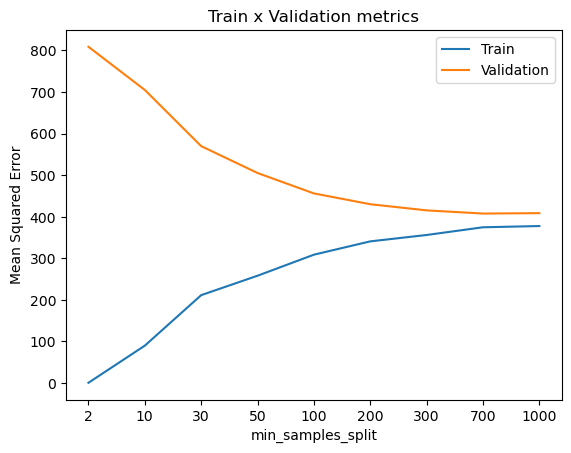

In [126]:
mse_list_train = []
mse_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train, y_train)
    mse_val = mean_squared_error(predictions_val, y_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

### Look at max_depth_list

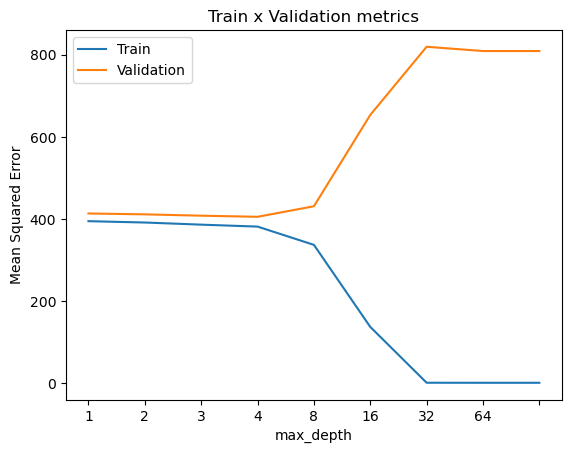

In [127]:
mse_list_train = []
mse_list_val = []

for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeRegressor(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train, y_train)
    mse_val = mean_squared_error(predictions_val, y_val)
    
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])



## Choose best hyperparameters for decision tree model

In [128]:
# Find the index of the minimum MSE in the validation list for min_samples_split
best_min_samples_split = min_samples_split_list[mse_list_val.index(min(mse_list_val))]

# Find the index of the minimum MSE in the validation list for max_depth
best_max_depth = max_depth_list[mse_list_val.index(min(mse_list_val))]

print('Best min_samples_split: ', best_min_samples_split)
print('Best max_depth: ', best_max_depth)


Best min_samples_split:  50
Best max_depth:  4


In [129]:
decision_tree_model = DecisionTreeRegressor(min_samples_split = best_min_samples_split,
                                             max_depth = best_max_depth,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [130]:
# Predictions for the train and validation sets
predictions_train = decision_tree_model.predict(X_train)
predictions_val = decision_tree_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(predictions_train, y_train)
mse_val = mean_squared_error(predictions_val, y_val)

# Print the metrics
print(f"Metrics train:\n\tMean Squared Error: {mse_train:.4f}")
print(f"Metrics validation:\n\tMean Squared Error: {mse_val:.4f}")

Metrics train:
	Mean Squared Error: 381.2712
Metrics validation:
	Mean Squared Error: 404.1268


### Visualizing the Decision Tree

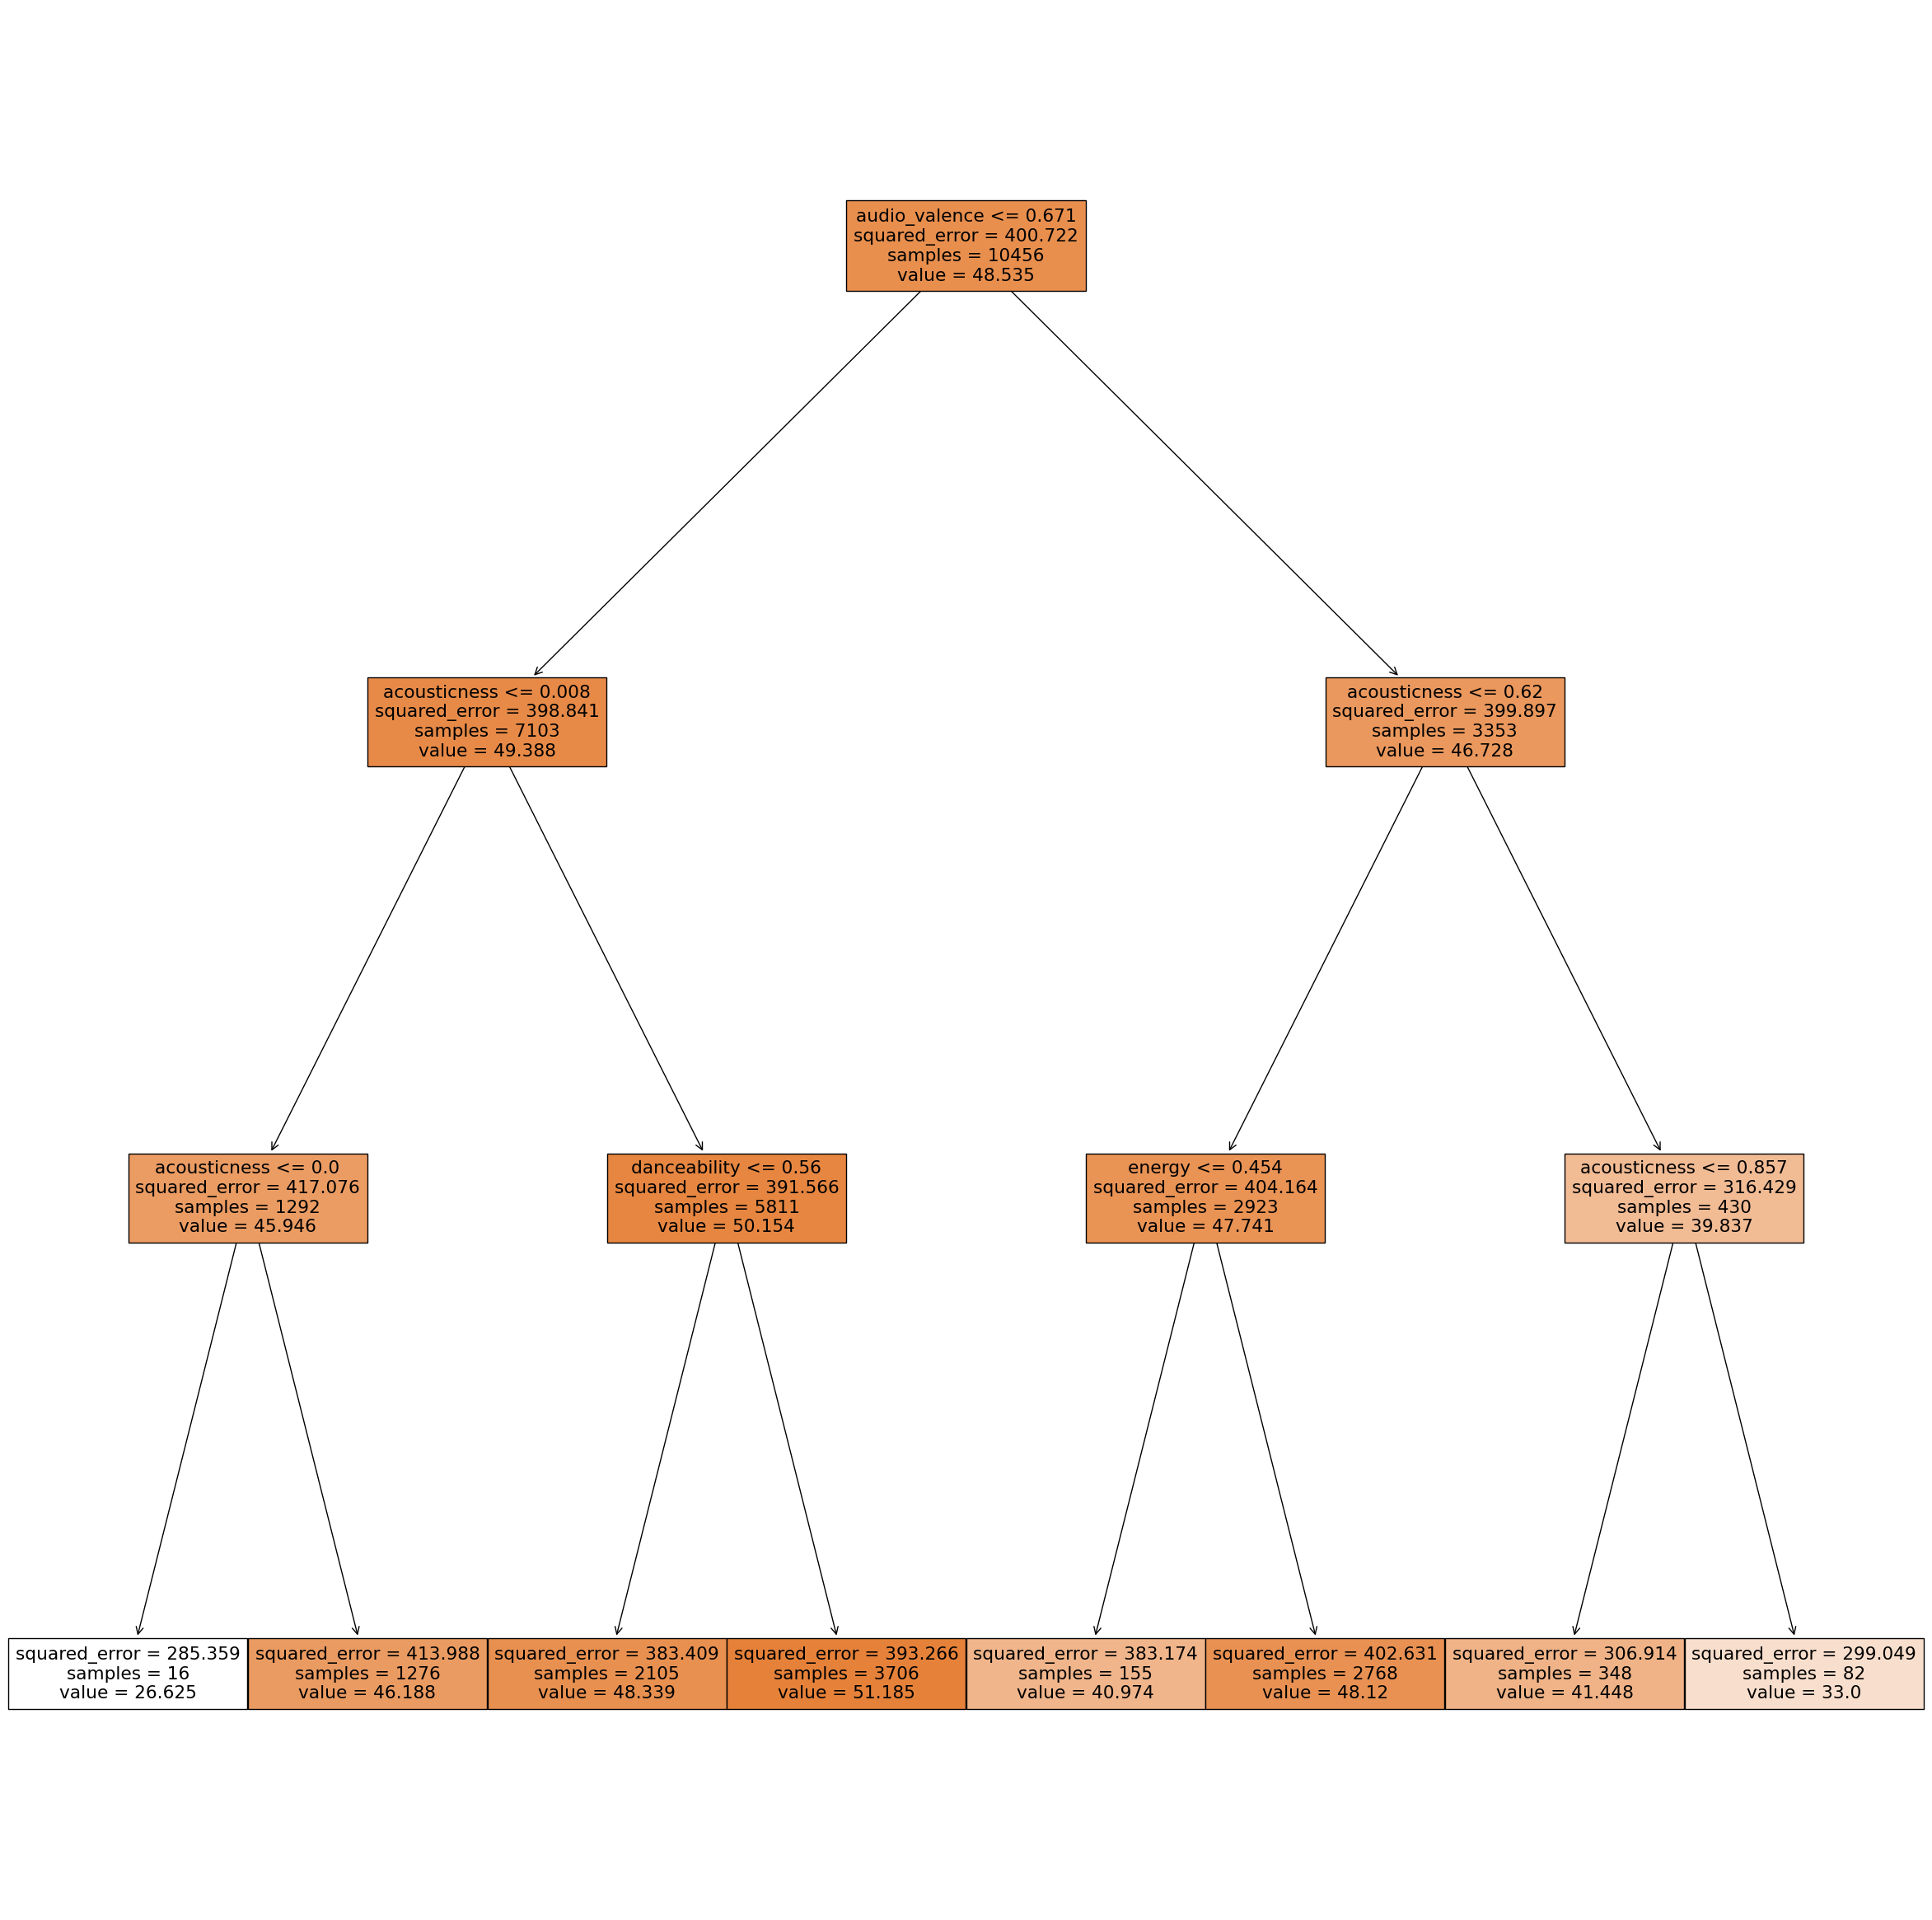

In [114]:
plt.figure(figsize=(30,30))
plot_tree(decision_tree_model, feature_names=X_train.columns.tolist(), filled=True)
plt.show()

### Feature Importance

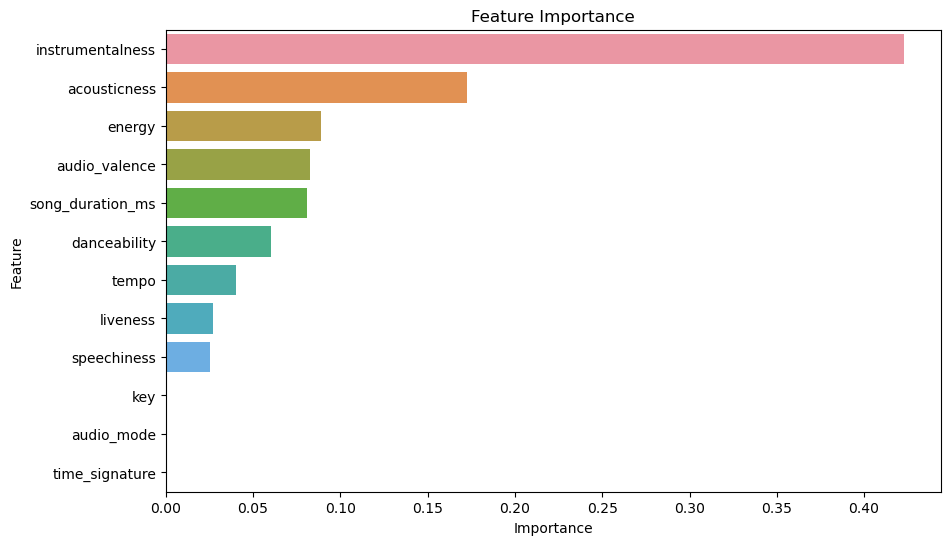

In [50]:
importances = decision_tree_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [51]:
number_of_tests = 200
sum_difference = 0

for i in range(number_of_tests):
    # Assuming your model was trained on data with 14 features
    prediction = decision_tree_model.predict(X_val.iloc[i].values.reshape(1, 12))
    print(f"{prediction} -> {y_val.iloc[i]}")
    sum_difference += np.power(prediction - y_val.iloc[i], 2)

# Calculate Mean Squared Error (MSE)
mse = sum_difference / number_of_tests
print(f"MSE: {mse}")

[54.36924686] -> 1
[50.27024723] -> 70
[54.36924686] -> 69
[50.27024723] -> 45
[50.57594449] -> 68
[54.36924686] -> 47
[50.27024723] -> 28
[39.45425361] -> 32
[45.28] -> 56
[48.70725389] -> 24
[43.66037736] -> 66
[43.66037736] -> 30
[39.45425361] -> 52
[50.57594449] -> 34
[56.73809524] -> 57
[54.36924686] -> 38
[39.45425361] -> 45
[45.28] -> 57
[45.28] -> 0
[51.51703704] -> 60
[46.43518519] -> 59
[50.57594449] -> 84
[54.36924686] -> 48
[46.43518519] -> 58
[45.28] -> 57
[48.70725389] -> 13
[46.3559322] -> 19
[48.70725389] -> 49
[54.36924686] -> 37
[54.36924686] -> 20
[54.36924686] -> 52
[50.27024723] -> 2
[48.04761905] -> 49
[48.70725389] -> 61
[43.66037736] -> 26
[54.36924686] -> 7
[48.70725389] -> 1
[48.04761905] -> 54
[50.27024723] -> 53
[54.36924686] -> 60
[48.70725389] -> 22
[50.57594449] -> 71
[43.93642612] -> 64
[46.43518519] -> 33
[50.57594449] -> 2
[43.93642612] -> 51
[43.93642612] -> 42
[43.66037736] -> 46
[51.51703704] -> 53
[50.27024723] -> 56
[54.36924686] -> 60
[39.4542536

c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
c:\Users\emile\anaconda3\lib\site-packages\sklearn\base.py:450: U

## Randomforest

In [52]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

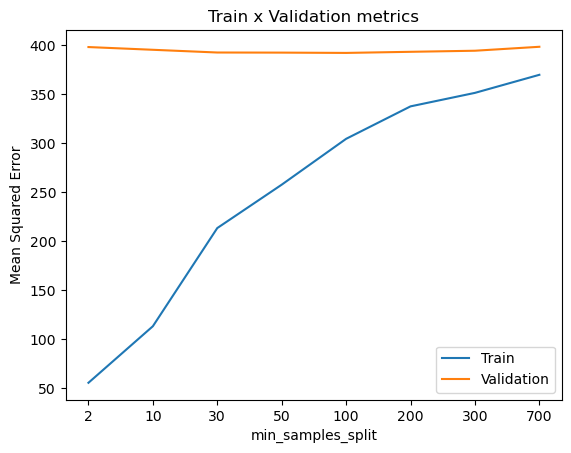

In [53]:
mse_list_train = []
mse_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestRegressor(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

In [54]:
mse_list_train = []
mse_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestRegressor(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

KeyboardInterrupt: 

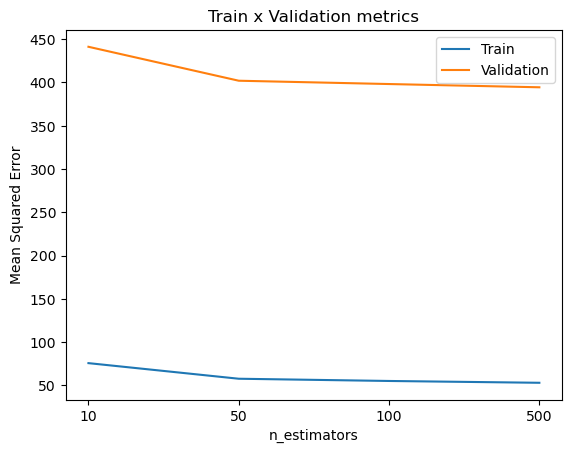

In [ ]:
mse_list_train = []
mse_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestRegressor(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    mse_train = mean_squared_error(predictions_train,y_train)
    mse_val = mean_squared_error(predictions_val,y_val)
    mse_list_train.append(mse_train)
    mse_list_val.append(mse_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(mse_list_train)
plt.plot(mse_list_val)
plt.legend(['Train','Validation'])

In [ ]:
# Find the index of the minimum MSE in the validation list for min_samples_split
best_min_samples_split = min_samples_split_list[mse_list_val.index(min(mse_list_val))]

# Find the index of the minimum MSE in the validation list for max_depth
best_max_depth = max_depth_list[mse_list_val.index(min(mse_list_val))]

# Find the index of the minimum MSE in the validation list for n_estimators
best_n_estimators = n_estimators_list[mse_list_val.index(min(mse_list_val))]

print('Best min_samples_split: ', best_min_samples_split)
print('Best max_depth: ', best_max_depth)
print('Best n_estimators: ', best_n_estimators)

Best min_samples_split:  50
Best max_depth:  16
Best n_estimators:  500


In [ ]:
random_forest_model = RandomForestRegressor(n_estimators = 50,
                                             max_depth = 64, 
                                             min_samples_split = 100).fit(X_train,y_train)

In [ ]:
# Predictions for the train and validation sets
predictions_train = random_forest_model.predict(X_train)
predictions_val = random_forest_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(predictions_train, y_train)
mse_val = mean_squared_error(predictions_val, y_val)

# Print the metrics
print(f"Metrics train:\n\tMean Squared Error: {mse_train:.4f}")
print(f"Metrics validation:\n\tMean Squared Error: {mse_val:.4f}")

Metrics train:
	Mean Squared Error: 304.8337
Metrics validation:
	Mean Squared Error: 394.3491
